In [159]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import (Layer, Input, Conv2D, BatchNormalization, Dropout, Dense, 
                                     Flatten, Reshape, Conv2DTranspose)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [169]:
class Encoder(Layer):
    def __init__(self, num_conv_layers, encoder_conv_filters, encoder_strides,
                 encoder_output_dim, dropout_rate=None, input_dim=None, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate

        self.conv_layers = []
        for i in range(num_conv_layers):
            conv_layer = Conv2D(filters=encoder_conv_filters[i],
                                kernel_size=(3, 3),
                                strides=encoder_strides[i],
                                padding='same',
                                activation='relu',
                                name=f'encoder_conv_{i}')
            self.conv_layers.append(conv_layer)
    
        self.dense_layer = Dense(encoder_output_dim, name='encoder_output')
        
    
    def model(self):
        model_input = Input(shape=self.input_dim)
        return Model(model_input, self.call(model_input))
            

    def call(self, inputs):
        x = inputs
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        x = Flatten()(x)
        self.shape_before_flat = K.int_shape(x)[1:] 
        x = self.dense_layer(x)
        return x
    
    
class Decoder(Layer):
    def __init__(self, num_conv_layers, decoder_conv_filters, shape_before_flat, 
                 decoder_strides, dropout_rate=None, input_dim=None, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.dense = Dense(np.prod(shape_before_flat), activation='relu')
        self.reshape = Reshape(shape_before_flat)
        self.conv_layers = []
        for i in range(num_conv_layers - 1):
            conv_layer = Conv2DTranspose(filters=decoder_conv_filters[i],
                                         kernel_size=(3, 3),
                                         strides=decoder_strides[i],
                                         padding='same',
                                         activation='relu',
                                         name=f'decoder_conv_{i}')
            self.conv_layers.append(conv_layer)
            
        self.output_layer = Conv2DTranspose(filters=1,
                                            kernel_size=(3, 3),
                                            strides=decoder_strides[-1],
                                            padding='same',
                                            activation='sigmoid', 
                                            name=f'output_layer')
        
        
    def model(self):
        model_input = Input(shape=self.input_dim)
        return Model(model_input, self.call(model_input))

        
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        return self.output_layer(x)
    
    
class Autoencoder(Model):
    def __init__(self, 
                 num_conv_layers,
                 encoder_conv_filters,
                 encoder_strides,
                 encoder_output_dim, 
                 input_dim, 
                 decoder_conv_filters, 
                 shape_before_flat, 
                 decoder_strides,
                 dropout_rate=None, 
                 **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = Encoder(num_conv_layers = num_conv_layers, 
                               encoder_conv_filters = encoder_conv_filters,
                               encoder_strides = encoder_strides,
                               encoder_output_dim = encoder_output_dim, 
                               input_dim = input_dim,
                               dropout_rate = dropout_rate)
        self.decoder = Decoder(num_conv_layers = num_conv_layers, 
                               decoder_conv_filters = decoder_conv_filters, 
                               shape_before_flat = shape_before_flat, 
                               decoder_strides = decoder_strides,
                               input_dim=(2,),
                               dropout_rate=dropout_rate)
    
        
    def call(self, inputs):
        encoder_output = self.encoder(inputs)
        decoder_output = self.decoder(encoder_output)
        return decoder_output

In [170]:
num_conv_layers = 4
encoder_conv_filters = [32, 64, 64, 32]
encoder_output_dim=2
encoder_strides = [1,2,2,1]
input_dim=(28, 28, 1)

encoder_model = Encoder(num_conv_layers=num_conv_layers, 
                        encoder_conv_filters=encoder_conv_filters, 
                        encoder_output_dim=encoder_output_dim, 
                        encoder_strides=encoder_strides,
                        input_dim=input_dim)
encoder_model.model().summary()

Model: "functional_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 32)          18464     
_________________________________________________________________
flatten_34 (Flatten)         (None, 1568)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)               

In [171]:
num_conv_layers = 4
decoder_conv_filters = [32, 64, 64, 32]
encoder_output_dim=2
decoder_strides = [1,2,2,1]
input_dim=(2,)

decoder_model = Decoder(num_conv_layers = num_conv_layers, 
                        decoder_conv_filters = decoder_conv_filters, 
                        shape_before_flat = (7, 7, 32), 
                        decoder_strides = decoder_strides,
                        input_dim=input_dim,
                        dropout_rate=None, 
                        name='decoder')
decoder_model.model().summary()

Model: "functional_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1568)              4704      
_________________________________________________________________
reshape_26 (Reshape)         (None, 7, 7, 32)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 7, 7, 32)          9248      
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        18496     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 28, 28, 64)        36928     
_________________________________________________________________
output_layer (Conv2DTranspos (None, 28, 28, 1)       

In [172]:
model = Autoencoder(num_conv_layers = num_conv_layers,
                    encoder_conv_filters = encoder_conv_filters,
                    encoder_strides = encoder_strides,
                    encoder_output_dim = encoder_output_dim, 
                    input_dim = (28, 28, 1), 
                    decoder_conv_filters = decoder_conv_filters, 
                    shape_before_flat = shape_before_flat, 
                    decoder_strides = decoder_strides)

In [177]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

epochs = 5
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(x_train[:1000]):
        with tf.GradientTape() as tape:
            reconstructed = model([x_batch_train])
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

Start of epoch 0
Start of epoch 1
Start of epoch 2
Start of epoch 3
Start of epoch 4


In [75]:
num_conv_layers = 4
conv_units = 64
encoder_output_dim=2
strides = [1,2,2,1]
input_dim=(28, 28, 1)
dropout_rate=0.2

encoder_input = Input(shape=input_dim)
x = encoder_input
for i in range(num_conv_layers):
    conv_layer = Conv2D(filters=conv_units,
                        kernel_size=(3, 3),
                        strides=strides[i],
                        padding='same',
                        activation='relu',
                        name=f'encoder_conv_{i}')
    x = conv_layer(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=dropout_rate)(x)

shape_before_flat = K.int_shape(x)[1:]
x = Flatten()(x)
dense_layer = Dense(encoder_output_dim, name='encoder_output')
encoder_output = dense_layer(x)

encoder_model = Model(encoder_input, encoder_output)
encoder_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        36928     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_14 (Flatten)         (None, 3136)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)               

In [76]:
shape_before_flat

(7, 7, 64)

In [176]:
decoder_input = Input(shape=encoder_output_dim)
x = Dense(np.prod(shape_before_flat))(decoder_input)
x = Reshape(shape_before_flat)(x)

for i in range(num_conv_layers - 1):
    conv_layer = Conv2DTranspose(filters=conv_units,
                                 kernel_size=(3, 3),
                                 strides=strides[i], 
                                 padding='same',
                                 activation='relu',
                                 name=f'decoder_conv_{i}')
    x = conv_layer(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=dropout_rate)(x)

output_layer = Conv2DTranspose(filters=1,
                               kernel_size=(3, 3),
                               strides=1, 
                               padding='same',
                               activation='sigmoid',
                               name=f'decoder_conv_final')
x = output_layer(x)
decoder_output = x

decoder_model = Model(decoder_input, decoder_output)

decoder_model.summary()

Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 7, 7, 64)          36928     
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 28, 28, 64)        36928     
_________________________________________________________________
decoder_conv_final (Conv2DTr (None, 28, 28, 1)       

In [132]:
model_input = encoder_input
model_output = decoder_model(encoder_output)

model = Model(encoder_input, model_output)


def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

model.compile(optimizer='adam', loss=r_loss)
model.fit(x_train[:1000], x_train[:1000], epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 57ms/step - loss: 0.1555
Epoch 2/10
32/32 [==============================] - 2s 59ms/step - loss: 0.1096
Epoch 3/10
32/32 [==============================] - 2s 59ms/step - loss: 0.1096
Epoch 4/10
32/32 [==============================] - 2s 56ms/step - loss: 0.1096
Epoch 5/10
32/32 [==============================] - 2s 55ms/step - loss: 0.1096: 0s - los
Epoch 6/10
32/32 [==============================] - 2s 56ms/step - loss: 0.1096: 0s - loss
Epoch 7/10
32/32 [==============================] - 2s 60ms/step - loss: 0.1096: 0s 
Epoch 8/10
32/32 [==============================] - 2s 59ms/step - loss: 0.1096
Epoch 9/10
32/32 [==============================] - 2s 63ms/step - loss: 0.1096
Epoch 10/10
32/32 [==============================] - 2s 69ms/step - loss: 0.1096


In [117]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [118]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [180]:
model.fit(x_train[:1000], x_train[:1000], epochs=10)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [178]:
res = model.predict(x_test[:3])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


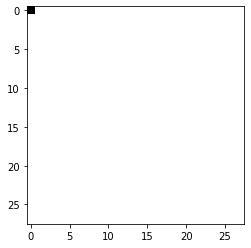

In [179]:
plt.imshow(res[1], cmap='gray_r')

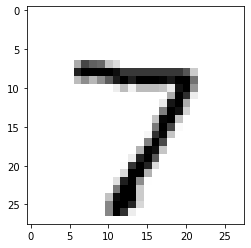

In [175]:
plt.imshow(x_test[0], cmap='gray_r')